# Musical instruments prices
### A study of the musical instruments market in Sri Lanka

Author: Leandro Hornos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import json

from wordcloud import WordCloud

In [2]:
df = pd.read_csv("raw-data.csv", encoding="utf-8", parse_dates=["published_date"])

## Cleaning the dataset

Let's take a look at data that we imported from the csv

In [3]:
df.head(3)

,Title,Sub_title,Price,Instrument_Type,Condition,Location,Description,Post_URL,Seller_name,Seller_type,published_date
0,Yamaha (SY-77) Music Synthesizer for sale,"Posted on 04 Oct 7:11 pm, Ja-Ela, Gampaha","Rs 39,000",Keyboard / Piano,Used,"Ja-Ela, Gampaha",Â°â¢Â°Sri Lanka's Largest Digital Piano Selle...,https://ikman.lk/en/ad/yamaha-sy-77-music-synt...,Seven Star International,Member,2021-10-04 19:11:00
1,SRX-718 BASS BIN (PAIR) for sale,"Posted on 10 Oct 7:54 pm, Kadawatha, Gampaha","Rs 77,500",Studio / Live Music Equipment,New,"Kadawatha, Gampaha",â¡Watts 3200â¡â¡Treated Plywoodâ¡,https://ikman.lk/en/ad/srx-718-bass-bin-pair-f...,Sasiru Super Sonics,Member,2021-10-10 19:54:00
2,Piano (Malcom Mendis Piano) for sale,"Posted on 13 Oct 12:43 pm, Kandana, Gampaha","Rs 130,000",Keyboard / Piano,Used,"Kandana, Gampaha","Sri Lanka's Biggest Piano Sale, Reasonable pri...",https://ikman.lk/en/ad/piano-malcom-mendis-pia...,Sell Fast | à¶à¶³à·à¶± | MCI Ikman à¶¯à·à¶±...,Member,2021-10-13 12:43:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5167 entries, 0 to 5166
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            5167 non-null   object        
 1   Sub_title        5167 non-null   object        
 2   Price            5167 non-null   object        
 3   Instrument_Type  5167 non-null   object        
 4   Condition        5167 non-null   object        
 5   Location         5167 non-null   object        
 6   Description      5167 non-null   object        
 7   Post_URL         5167 non-null   object        
 8   Seller_name      5167 non-null   object        
 9   Seller_type      5167 non-null   object        
 10  published_date   5167 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(10)
memory usage: 444.2+ KB


We can se that we have no missing values on this dataset. 

In [5]:
print(df.Condition.unique())
print(df.Seller_type.unique())

['Used' 'New']
['Member' 'Premium-Member']


As suspected, both variables are binaries. We will change those of a new pair of variables that take 1s and 0s as it's possible values

**Prices**

In [6]:
# We want to convert prices to numbers:

def parsePrice(text):
    text = text.replace("Rs ","")
    text = text.replace(",","")
    return int(text)

df["Price_value"] = df["Price"].apply(lambda x: parsePrice(x))

**Location**<br>
The location field contains the name of the neighborhood/suburb and the city, separated by a comma. It would be a good idea to split this columns in two.

In [7]:
def getLocation(location, option="city"):
    locdata = location.split(",")
    if option == "city":
        return locdata[1].strip()
    elif option == "neighborhood":
        return locdata[0].strip()
    else:
        return np.nan


df[["Neigborhood", "City"]] = df['Location'].apply(lambda x: pd.Series([getLocation(x,"neighborhood"),getLocation(x,"city")]))
df.drop(["Location"],axis=1, inplace=True)
df.head(3)

,Title,Sub_title,Price,Instrument_Type,Condition,Description,Post_URL,Seller_name,Seller_type,published_date,Price_value,Neigborhood,City
0,Yamaha (SY-77) Music Synthesizer for sale,"Posted on 04 Oct 7:11 pm, Ja-Ela, Gampaha","Rs 39,000",Keyboard / Piano,Used,Â°â¢Â°Sri Lanka's Largest Digital Piano Selle...,https://ikman.lk/en/ad/yamaha-sy-77-music-synt...,Seven Star International,Member,2021-10-04 19:11:00,39000,Ja-Ela,Gampaha
1,SRX-718 BASS BIN (PAIR) for sale,"Posted on 10 Oct 7:54 pm, Kadawatha, Gampaha","Rs 77,500",Studio / Live Music Equipment,New,â¡Watts 3200â¡â¡Treated Plywoodâ¡,https://ikman.lk/en/ad/srx-718-bass-bin-pair-f...,Sasiru Super Sonics,Member,2021-10-10 19:54:00,77500,Kadawatha,Gampaha
2,Piano (Malcom Mendis Piano) for sale,"Posted on 13 Oct 12:43 pm, Kandana, Gampaha","Rs 130,000",Keyboard / Piano,Used,"Sri Lanka's Biggest Piano Sale, Reasonable pri...",https://ikman.lk/en/ad/piano-malcom-mendis-pia...,Sell Fast | à¶à¶³à·à¶± | MCI Ikman à¶¯à·à¶±...,Member,2021-10-13 12:43:00,130000,Kandana,Gampaha


**Text fields**<br>
We can see that text fields are filled with strange characters. # If we take a look at the "Description" column, we will see some weird characters mixed with the text

In [8]:
# We define a function to remove every non ascii character

def removeNonAsciiChars(text):
    return "".join(char for char in text if ord(char) <128)
    
df["Description"] = df["Description"].apply(removeNonAsciiChars)
df["Title"] = df["Title"].apply(removeNonAsciiChars)

But, even though this cleans some of the fields, there are many that are plain unusable. Most of the descriptions are filleds with strange characters, but only a few title fields are completely unusable. We can se it is only about 70 entries:

In [9]:
# Those rows cannot be used, so we drop them
df = df.sort_values(["Title"], ascending=False)
df[["Title", "Description"]].iloc[60:75]

,Title,Description
3355,lexicon effect for sale,Good made in usa.110v.call Message
1962,les poul guitar for sale,Harly Benton guitar ..brand new ..super tone q...
195,les paul guitar for sale,
4335,korg sp-170 piano for sale,Korg sp-170 piono good sounds an conditions Im...
4033,keyboard piano for sale,Good condition
1819,keyboard for sale,Yamaha E253
3466,keyboard for sale,"Cash on delivery available Wholesale,..."
3669,keyboard for sale,Good condition No errors With keyboard bag and...
4809,keyboard for sale,Brand nd new keyboard. Keys 61. Free dilivery....
4806,keyboard for sale,Brand new 61 keys keyboard. Free mic. Free not...


In [10]:
df.drop(df.index[:70], inplace=True)
df[["Title", "Description"]].iloc[:10]

,Title,Description
3913,keyboard for sale,CELEBRATE MUSIC HOUSE 077...
3910,keyboard for sale,CELEBRATE MUSIC HOUSE 077...
1235,karaoke speaker-LA Brand for sale,"Model :PE10 -Battery Powered Two way 10"" Full ..."
4198,john packer jp043 g soprano for sale,john packer jp043 g soprano Brand new
1206,jbl srx 725 for sale,jbl srx 725 brand new warrenty7000 w
2817,jbl srx 725 718 qsc amp soundcraft dbx for sale,brand new jbl srx 725 6000 w 750 his jbl 2226h...
3092,jbl srx 715 for sale,2000 w jbl srx 715 sale from dubai
176,jbl srx 715 (IMPORTED) TOP (PAIR) for sale,jbl srx 715 (IMPORTED) TOP (PAIR)2000 rms bra...
175,jbl srx 712 m for sale,jbl srx 712 mbrand new 1500 w
2819,jbl srx 712 2500 amp mixer for sale,brand new jbl srx 712 proel 2500 w amplifier6 ...


Everything looks fine, but whe see the irrelevan phrase "for sale" in most of the titles. We are going to remove it before going on.

In [11]:
df["Title"] = df["Title"].apply(lambda x: x.replace(" for sale", ""))

# Check that the substring is gone
df["Title"].iloc[:10]

3913                                  keyboard
3910                                  keyboard
1235                  karaoke speaker-LA Brand
4198               john packer jp043 g soprano
1206                               jbl srx 725
2817    jbl srx 725 718 qsc amp soundcraft dbx
3092                               jbl srx 715
176          jbl srx 715 (IMPORTED) TOP (PAIR)
175                              jbl srx 712 m
2819                jbl srx 712 2500 amp mixer
Name: Title, dtype: object

## Data Expansion

We have a title variable that, contains a short text describing the product. It would be interesting to be able to identify if the product is an instrument or an accesory and, ideally, to get the name of the item. That would allow us to perform a deeper analisis, detecting trends on items itself and no only broad categories.

### Extracting the product from the Title

Even though the dataset only contains a broad classification of products, the title of each entry contains a detailed description of what it is, from which the product can be extracted. We know that the dataset contains mainly musical instruments, that are quite easy to identify, and all sorts of accesories, parts and devices that will not be that easy to extract.<br>
The aproach that we are going to take is to obtain a list in english of the most popular musical instruments in the world. We will also make a list of common music related products. We will search for this keywords in the titles, and the info about the matches will be stored in two new columns, one containing the name of the product and one a category label in order to discriminate actual musical instruments from other products.

In [12]:
# As a simple first approach, we are going to use a list of common instruments
# and we are going to check for each instrument in each title text

def extractKeyword(text, keywords):
    # Recieves a dictionary with lists of
    # types of products
    for productType in list(keywords.keys()):
        for product in keywords[productType]:
            if product.upper() in text.upper():
                return (product.capitalize()+","+productType)
    # If there are no matches return NaN
    return np.nan

In [13]:
with open("resources/instruments_names.json") as file:
    keywords = json.load(file)

print(keywords["equipment"])
df["Product"] = df.apply(lambda row: extractKeyword(row["Title"], keywords), axis=1)

def getCategory(value, option="category"):
    if type(value) != str:
        return np.nan
    data = value.split(",")
    if option == "product":
        return data[0].strip()
    elif option == "category":
        return data[1].strip()
    else:
        return np.nan


df[["Product", "Category"]] = df['Product'].apply(lambda x: pd.Series([getCategory(x,"product"), getCategory(x,"category")]))

print(100 * int(df[["Product"]].count()) /int(df[["Title"]].count())," % of the products have been guessed from the title\n")
df.head()

['speaker', 'microphone', 'mic', 'mixer', 'effect', 'recorder', 'amplifier', 'light', 'console', 'card', 'monitor']
72.47400431626447  % of the products have been guessed from the title



,Title,Sub_title,Price,Instrument_Type,Condition,Description,Post_URL,Seller_name,Seller_type,published_date,Price_value,Neigborhood,City,Product,Category
3913,keyboard,"Posted on 01 Nov 10:36 am, Galle City, Galle","Rs 11,500",Keyboard / Piano,Used,CELEBRATE MUSIC HOUSE 077...,https://ikman.lk/en/ad/keyboard-for-sale-galle-47,Celebrate Music House,Member,2021-11-01 10:36:00,11500,Galle City,Galle,Keyboard,instrument
3910,keyboard,"Posted on 01 Nov 10:48 am, Galle City, Galle","Rs 8,500",Keyboard / Piano,Used,CELEBRATE MUSIC HOUSE 077...,https://ikman.lk/en/ad/keyboard-for-sale-galle-48,Celebrate Music House,Member,2021-11-01 10:48:00,8500,Galle City,Galle,Keyboard,instrument
1235,karaoke speaker-LA Brand,"Posted on 28 Sep 10:21 am, Kelaniya, Gampaha","Rs 19,750",Studio / Live Music Equipment,New,"Model :PE10 -Battery Powered Two way 10"" Full ...",https://ikman.lk/en/ad/karaoke-speaker-la-bran...,MV AUDIO,Member,2021-09-28 10:21:00,19750,Kelaniya,Gampaha,Speaker,equipment
4198,john packer jp043 g soprano,"Posted on 28 Oct 4:36 pm, Kolonnawa, Colombo","Rs 155,000",Woodwind / brass,New,john packer jp043 g soprano Brand new,https://ikman.lk/en/ad/soprano-for-sale-colombo,Dilhan siriwardena,Member,2021-10-28 16:36:00,155000,Kolonnawa,Colombo,NaN,NaN
1206,jbl srx 725,"Posted on 28 Sep 8:38 pm, Negombo, Gampaha","Rs 150,000",Studio / Live Music Equipment,New,jbl srx 725 brand new warrenty7000 w,https://ikman.lk/en/ad/jbl-srx-725-for-sale-ga...,Canon Sound Music Center,Member,2021-09-28 20:38:00,150000,Negombo,Gampaha,NaN,NaN


In [14]:
df.sort_index(inplace=True)
df[df.Product.notnull()][["Title", "Product", "Category","Description"]].head()

,Title,Product,Category,Description
0,Yamaha (SY-77) Music Synthesizer,Synthesizer,instrument,Sri Lanka's Largest Digital Piano Seller Dire...
2,Piano (Malcom Mendis Piano),Piano,instrument,"Sri Lanka's Biggest Piano Sale, Reasonable pri..."
3,Yamaha Semi Acoustic Guitars,Guitar,instrument,Yamaha semi acoustic guitar. Model- FX310A. B...
4,Yamaha Guitar,Guitar,instrument,Yamaha fG-151 Made in Japan Good condition Goo...
5,Violin,Violin,instrument,Brand new ConditionFull set With BoxBrand - Ne...


In [15]:
print ("This are the Instrumets that where identified:\n")
df.Product.unique()

This are the Instrumets that where identified:



array(['Synthesizer', nan, 'Piano', 'Guitar', 'Violin', 'Card',
       'Melodica', 'Cymbal', 'Drum', 'Keyboard', 'Pedal', 'Pickup',
       'Speaker', 'Monitor', 'Bass guitar', 'Microphone', 'Bongo', 'Case',
       'Strings', 'Flute', 'Serpina', 'Mic', 'Organ', 'Recorder',
       'Amplifier', 'Trumpet', 'Mixer', 'Light', 'Console', 'Effect',
       'Saxophone', 'Cello', 'Mandolin', 'Clarinet', 'Ukulele', 'Vinyl',
       'Harp', 'Sitar', 'Grand piano', 'Viola', 'Tambourine', 'Accordian',
       'Glockenspiel', 'Harmonica', 'Trombone'], dtype=object)

Let's take a look at the products that we could not guess. What are they? One way to get a better idea of what kind of products are being left out is to make a word cloud of the titles of those unclassified products.

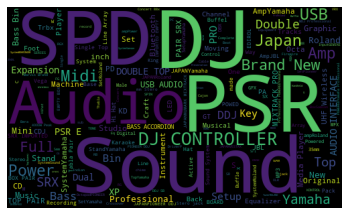

In [16]:
def showWordCloud(text):
    wordCloud = WordCloud(width=500, height=300, random_state=42, max_font_size=120).generate(text)
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.show()
    
allTitles = "".join(titles for titles in df["Title"][df.Product.isnull()])

showWordCloud(allTitles)


**Note:** After making this wordcloud, several products were added to the products list in the json files. This allowed to increase the number of product macthes from 43% to 68%

### Guessing the Brand

This website (https://www.americanmusical.com/BrandList.aspx) contains a broad list of companies that comercialize musical instruments. The list was copyied and pasted on a text file. Since it is a list of links, other elements were copied aswell, so the list needs to be cleaned fist.

In [17]:
# The following lines show the process followed to obtain the brand names from the txt

with open("resources/instrument_brands_list.txt") as file:
    data = file.read().replace("\n",",")

# The txt contains the brand and the number of items in source's web store
# The lines have a structure of the kind ItemName3 items(3)
# Let's use a regular expresion to remove those substrings

data = re.sub(r"([0-9])+ items?\([0-9]+\)","",data)

# store the brands in a list 
brandlist = data.split(",")

# Check the result
print(brandlist[:10])

# Write this into a JSON
brands = {"Brands":brandlist}
with open('resources/brands.json', 'w') as fp:
    json.dump(brands, fp)


['2BOX Drums', '512 Audio', 'Abasi Guitars', 'Ableton', 'Access', 'Acon Digital', 'Adam Audio', 'ADJ Lighting', 'Ahead', 'AirTurn']


In [18]:
# Now we define a function to check if the text contains a brand

def guessBrand(text):
    with open("resources/Brands.json") as file:
        data = json.load(file)
    brand = np.nan
    for name in data["Brands"]:
        if name.upper() in text.upper():
            return name.capitalize()
    return brand


df["Brand"] = df.apply(lambda row: guessBrand(row["Title"]), axis=1)

print(100 * int(df[["Brand"]].count()) /int(df[["Title"]].count())," % of the brands have been guessed from the title\n")
df[["Brand"]].info()

33.19599764567393  % of the brands have been guessed from the title

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5097 entries, 0 to 5166
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Brand   1692 non-null   object
dtypes: object(1)
memory usage: 79.6+ KB


In [19]:
df[df.Brand.notnull()][["Title", "Product", "Description", "Brand"]].head()

,Title,Product,Description,Brand
0,Yamaha (SY-77) Music Synthesizer,Synthesizer,Sri Lanka's Largest Digital Piano Seller Dire...,Yamaha
3,Yamaha Semi Acoustic Guitars,Guitar,Yamaha semi acoustic guitar. Model- FX310A. B...,Yamaha
4,Yamaha Guitar,Guitar,Yamaha fG-151 Made in Japan Good condition Goo...,Yamaha
11,"Fender 41"" box guitar",Guitar,Perfect sound and toneF cut model Brand new Is...,Fender
20,Yamaha PSR 433 Keyboard,Keyboard,Yamaha Organ in good condition with Hercules a...,Yamaha


In [20]:
df.Brand.unique()

array(['Yamaha', nan, 'Fender', 'Boss', 'Emg', 'Ibanez', 'Roland',
       'Numark', 'Tascam', 'Art', 'Zoom', 'Ams', 'Korg', 'Rme',
       'Behringer', 'Fishman', 'Jbl', 'Pioneer', 'Casio', 'Crown',
       'Shure', 'Marshall', 'Zildjian', 'Dbx', 'Sennheiser', 'Tama',
       'Soundcraft', 'Epiphone', 'M-audio', 'Sabian', 'Rcf', 'Gemini',
       'Peavey', 'Access', 'Native instruments', 'Line ', 'Mackie',
       'Nord', 'Rode', 'Mapex', 'Sony', 'Alesis', 'Nux', 'Remo', 'Akg',
       'Takamine', 'Luna', 'Vox', 'Pearl', 'Digitech', 'Cme', 'Jackson',
       "D'addario", 'Hohner', 'Bose', 'Medeli', 'Esp', 'Novation',
       'Lakland', 'Evans', 'Denon dj', 'Kawai', 'Washburn', 'Qsc',
       'Electro voice', 'Ampeg', 'Paiste', 'Warwick', 'Matrix', 'Audix',
       'Randall', 'Nektar', 'Apogee', 'Neutrik', 'Mxr', 'Reloop', 'Prs',
       'Skb', 'Focusrite', 'Gibson', 'Gator', 'Genelec', 'Laney', 'Rane',
       'Dunlop', 'Presonus', 'Lexicon', 'Tc helicon', 'Eminence',
       'Celestion', 'Steinber

In [21]:
df["Brand"].value_counts()

Yamaha        546
Roland        170
Jbl            86
Pioneer        75
Casio          64
             ... 
Lakland         1
Nord            1
Luna            1
Medeli          1
Pedaltrain      1
Name: Brand, Length: 96, dtype: int64

In [22]:
# We saved the processed data
df.to_csv("processed-data.csv")